# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
from typing import List, Dict, Tuple, Callable
import math
from copy import deepcopy
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [4]:
data = parse_data("concrete_compressive_strength.csv")

In [5]:
data[0]

[425.0, 106.3, 0.0, 151.4, 18.6, 936.0, 803.7, 3.0, 36.3]

In [6]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

In [7]:
cols=["0","1","2","3","4","5","6","7", "y", "est_y"]

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [8]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [9]:
folds = create_folds(data, 10)

In [10]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [11]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [12]:
train, test = create_train_test(folds, 0)

In [13]:
len(train)

927

In [14]:
len(train[0])

9

<a id="euclidean_dist"></a>
## euclidean_dist

This function calculates the euclidean distance between a group of training data
compared to a single point. 


* **data** List[List[float]]: list of data points with multiple numeric features
* **query** List[float]: a single data point with multiple features


**returns** List[float]: distances between each point in data to the query point

In [15]:
def euclidean_dist(data:List[List[float]],query:List[float])->List[float]:
    dist = []
    for rw in data:
        if len(rw) != len(query):
            print("The number of features between data and query doesn't match")
            return []
        sum = 0
        for col_index in range(len(rw) -1): #excluding making distance on label field
            diff = rw[col_index] - query[col_index]
            diff_squared = diff * diff
            sum += diff_squared
        diff_root = math.sqrt(sum)
        dist.append(diff_root)
    return dist



In [16]:
# data from the self check
d_test = [[.23,.81, .5],[.42,.78,.7],[.64,.23,.8],[.87,.19,.12],[.76,.43,.34]]
y_test = [.39, .63,.45]
dists_test = euclidean_dist(d_test,y_test )
dists_test

# check function returns a list
assert isinstance(dists_test, list)

#check the number of distances returned is length of data
assert len(dists_test)== len(d_test)

#check all values are positive (from the power and the square in algo)
for dist in dists_test:
    assert dist > 0

d_test2 = [[item[0]] for item in d_test]
dists_test2 = euclidean_dist(d_test2,y_test )
# check empty distance is returned if a mismatch in features
assert dists_test2 == []

The number of features between data and query doesn't match


<a id="find_top_k"></a>
## find_top_k

Finds the indexes of the closests neighbors. The closest k indexes are retuned


* **dists** List[float]: list of distances
* **k** int: number of neighbors to find


**returns** List[int]: indexes of closest neighbors

In [17]:
def find_top_k(dists: List[float], k:int)->List[int]:
    dists_copy = deepcopy(dists)
    closest_neighbors = []
    while len(closest_neighbors) < k:
        current_min = min(dists_copy)
        neighbor = dists.index(current_min)
        closest_neighbors.append(neighbor)
        
        dists_copy.remove(current_min) # remove from list to find next closest neighbor

    return closest_neighbors
    

In [18]:
dists_test = [9.1,2.2, 5.3, 6.5, 7.6, 1.3, 0.4, 8.6]
k_test = 3
len_dists = len(dists_test)
n = find_top_k(dists_test, k_test)

# check the number of items returned matches k
assert len(n) == k_test

#check only indexes are returned. No distances/floats returned
for item in n:
    assert isinstance(item, int)

# Check that the correct indexes are returned
assert n == [6, 5, 1]

# check length of distances stays the same
assert len(dists_test) == len_dists

<a id="knn"></a>
## knn

- Returns a list of predictions for each query.
- The prediction is from taking the average value of the
k nearest neighbors. 
- The neareness measure comes from the euclidean distance


* **data** List[List[float]]: list of data points to measure against the query points
* **queries** List[List[float]]:list of data points to make predictions of
* **k** int:number of neighbors in aggregate to make prediction


**returns** List[float]: returns a list of predictions

In [19]:
def knn(data:List[List[float]], queries:List[List[float]], k:int)-> List[float]:
    preds = []

    for query in queries:
        dists = euclidean_dist(data,query) # get distances
        
        neighbors = find_top_k(dists, k) # find closest neighbors
        
        label_index = len(query) - 1
        labels = [data[n_index][label_index] for n_index in neighbors] # getting values of neighbors
        
        est_y = round((sum(labels)/ k), 2) # make prediction for query point
        preds.append(est_y) # add column
    
    return preds

        

In [20]:
data_test =[[1,2,3],[3,3,3],[4,4,4],[4,5,6],[5,6,7],[4,4,4]]
queries_test= [[4,5,5],[2,2,2]]
data_len = len(data_test)
queries_len = len(queries_test)
labels_test = knn(data_test, queries_test, 2)
labels_test

#check number of prediction is same number of queries
assert len(labels_test) == len(queries_test)

#check predictions are floats. They are averages of labels
for label in labels_test:
    assert isinstance(label, float)

#check no changes in size happens to the data or query lists
assert len(data_test) == data_len and len(queries_test) == queries_len



<a id="null_model"></a>
## null_model

- Returns a list of predictions
- All prediction values will be the average label in the data set


* **data** List[List[float]]: list of data points to measure against the query points
* **queries** List[List[float]]:list of data points to make predictions of

**returns** List[float]: returns a list of predictions

In [21]:
def null_model(data: List[List[float]], queries:List[List[float]])-> List[float]:
    data_labels = [rw[-1] for rw in data]
    avg = round((sum(data_labels)/ len(data)), 2) 

    preds = [avg for query in queries]

    return preds

In [22]:
data_test =[[1,2,3],[3,3,3],[4,4,4],[4,5,6],[5,6,7],[4,4,4]]
queries_test= [[4,5,5],[2,2,2]]

preds_test = null_model(data_test, queries_test)

#check number of predictions matches number of queries
assert len(preds_test) == len(queries_test)

# check pred is the same value
assert preds_test[0] == preds_test[1]

#check pred is a float. Should be a label value not an index
assert isinstance(preds_test[0], float)

<a id="mse"></a>
## mse

- Returns the mean squared error of the predictions
- This function first finds the error between the prediction and actual value
- Then squares that value. 
- Then the average is take of the errors. 
- A low error rate is best. The closer to zero the better. 

* **labels** List[float]: list of true labels/the actual value
* **preds** List[float]:list predicted values

**returns** float: returns the mean squared error

In [23]:
def mse(labels:List[float], preds:List[float])-> float:
    sum = 0
    for index in range(len(labels)):
        diff = labels[index] - preds[index]
        diff_squared = diff * diff
        sum += diff_squared
    mse_val = round((sum / len(labels)),4)
    return mse_val


In [24]:
# data from self check MSE questions
y = [3.78,4.82,2.83,2.76,3.48]
y_hat =[3.32,5.21,2.97,2.37,3.29]
test_mse= mse(y, y_hat)

# check only one value returned. Not a list of errors
assert isinstance(test_mse, float)

# check the value is greater than zero. Zero means the is no errors aka perfect model
assert test_mse > 0

#check the mean squared error is the expected value
assert test_mse == .1143

<a id="print_errors"></a>
## print_errors

- print error function returns no value, but instead prints the errors like in the documentation
- An error rate per fold is printed
- At the end the average error rate is printed

* **error** List[float]: list of errors per fold
* **preds** str: name of the model


In [25]:
def print_errors(errors:List[float], model:str):
    print("Error Rate for model", model)
    for i in range(10):
        fold_num = i +1
        print("Fold",fold_num, "error rate:", errors[i] )
    # find average
    avg = sum(errors)/ len(errors)
    print("Mean=", avg)


In [26]:
# no unit test because this function is only for displaying output
# nothing is returned to a value

<a id="plot_val_curves"></a>
## plot_val_curves

- This function returns no value, but instead prints a validation curve
- The validation curves plots the error rate for both the training and test data
- The test curve with the lowest error rate is the optimal hyperparameter

* **x** List[int]: list of k values, the hyperparameters that were tuned
* **test** List[float]: list of test errors
* **train** List[float]: list of training errors

In [27]:
def plot_val_curves(x:List[int], test:List[float], train:List[float]):
    plt.plot(x, test, label ="test")
    plt.plot(x, train, label="train")
    plt.xlabel("K Values")
    plt.ylabel("Error Rate")
    plt.legend()
    plt.title("Validation Curves")
    plt.show()


<a id="z_score"></a>
## z_score

- Normalizes the data but transforming each column to be the z score
- All columns in the query data set are transformed except for the label column
- The label column is always the last column
- Z = X- Mean / Standard Deviation

* **data** List[List[float]]: list of training data. Data used to calc mean and standard deviation
* **query** List[List[float]]: data set to normalize

**returns** List[List[float]]: normalized data set

In [28]:
def z_score(data:List[List[float]], query:List[List[float]])-> List[List[float]]:
    means = []
    st_devs = []
    norm = deepcopy(query)

    for feature in range(len(data[0]) -1): # get data mean and stdev
        col = [row[feature] for row in data]
        mean = sum(col)/ len(col)
        diff = [ pow(( x- mean), 2) for x in col ]
        diff_sum = sum(diff)
        st_dev = pow(diff_sum/ len(col),.5)
        
        means.append(mean)
        st_devs.append(st_dev)
  
    for rw in range(len(query)):
        for col in range(len(query[rw])-1):
            z = (query[rw][col] - means[col])/ (st_devs[col])
            norm[rw][col] = round(z, 4) # normalize data
    return norm

In [29]:
x = [[1,2,3], [2,2,2], [1,6,4]]
y = [[4,5,6],[4,3,6]]
norm_y = z_score(x, y)

#check the original data set didnt get updated
assert y != norm_y

#check that the last row, label column, matches
# checking we did not normalize the label column
assert [ rw[-1] for rw in y] == [ rw[-1] for rw in norm_y]

#check that all data is present
assert len(y) == len(norm_y)
assert len(y[0]) == len(norm_y[0])

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).
If you're not sure what format the output should take, refer to the course notes and what they do for that particular topic/algorithm.

## Problem 1: kNN

Implement k Nearest Neighbors with k = 9.

In [30]:
train, test = create_train_test(folds, 0)
preds_knn9 = knn(train, test, 9)

frmt = "{:>6}"*10 # to print output nicely 
print(frmt.format(*cols)) #print out col names
for rw in range(len(test)):
    rw_est = deepcopy(test[rw])
    rw_est.append(preds_knn9[rw])
    print(frmt.format(*rw_est))


     0     1     2     3     4     5     6     7     y est_y
 425.0 106.3   0.0 151.4  18.6 936.0 803.7   3.0  36.3 57.28
 379.5 151.2   0.0 153.9  15.91134.3 605.0  56.0  54.9 54.36
 213.7  98.1  24.5 181.7   6.91065.8 785.4 100.0  53.9  46.2
 194.7   0.0 100.5 170.2   7.5 998.0 901.8 100.0 44.28 42.67
 425.0 106.3   0.0 151.4  18.6 936.0 803.7  28.0  61.8 62.87
 213.5   0.0 174.2 154.6  11.71052.3 775.5  56.0 51.43  42.0
 213.5   0.0 174.2 159.2  11.71043.6 771.9   3.0 15.61 29.15
 303.6 139.9   0.0 213.5   6.2 895.5 722.5  28.0 33.42 43.51
 213.5   0.0 174.2 154.6  11.71052.3 775.5  28.0 45.94 33.33
 181.4   0.0 167.0 169.6   7.61055.6 777.8 100.0 45.37 42.81
 198.6 132.4   0.0 192.0   0.0 978.4 825.5   7.0 14.64 16.59
 153.0 102.0   0.0 192.0   0.0 888.0 943.1  28.0 17.96 14.57
 297.8 137.2 106.9 201.3   6.0 878.4 655.3  28.0 53.52 42.59
 230.0   0.0 118.3 195.5   4.61029.4 758.6   3.0 10.03 21.05
 388.6  97.1   0.0 157.9  12.1 852.1 925.7  28.0  50.7 49.63
 116.0 173.0   0.0 192.0

### Problem 1 Discussion
- Problem 1 only provides predictions of the y column using the 9 nearests neighbors
- Since no metrics were requested for this problem, we can't make too many assumptions about the data
- Just by skimming the data, it looks like some predictions are very close to the actual value and others are very off

## Problem 2: Evaluation vs. The Mean

Using Mean Squared Error (MSE) as your evaluation metric, evaluate your implement above and the Null model, the mean.

In [31]:
# get test labels
null_errors = []
knn9_errors =[]

for i in range(10):
    train, test = create_train_test(folds, i)
    test_labels = [row[8] for row in test]
    # get the null model
    preds_null = null_model(train, test)
    #get 9NN
    preds_9nn = knn(train, test, 9)

    # compare the results
    null_mse = mse(test_labels, preds_null)
    knn9_mse = mse(test_labels, preds_9nn)
    null_errors.append(null_mse)
    knn9_errors.append(knn9_mse)
print_errors(knn9_errors, "9 Nearest Neighbors")
print("\n")
print_errors(null_errors, "Null")

Error Rate for model 9 Nearest Neighbors
Fold 1 error rate: 107.9585
Fold 2 error rate: 118.0468
Fold 3 error rate: 61.9127
Fold 4 error rate: 69.5383
Fold 5 error rate: 85.123
Fold 6 error rate: 84.0148
Fold 7 error rate: 82.8341
Fold 8 error rate: 83.9085
Fold 9 error rate: 82.3116
Fold 10 error rate: 125.0381
Mean= 90.06864


Error Rate for model Null
Fold 1 error rate: 299.9075
Fold 2 error rate: 282.2684
Fold 3 error rate: 281.579
Fold 4 error rate: 254.0969
Fold 5 error rate: 232.5995
Fold 6 error rate: 259.3946
Fold 7 error rate: 292.8486
Fold 8 error rate: 345.4663
Fold 9 error rate: 229.8771
Fold 10 error rate: 313.2853
Mean= 279.13232000000005


### Problem 2 Discussion
- This problem compares the 9NN model to the Null Model
- Overall, the 9NN model had better performance than the Null model. 
- The 9NN model had the lowest mean squared error. Although, the error rate is still pretty high
- The Null model had very high error rate on all folds. This is because all predictions are the same value
- Both models had variation of error rate between folds. No fold had the same error rate for either model

## Problem 3: Hyperparameter Tuning

Tune the value of k.

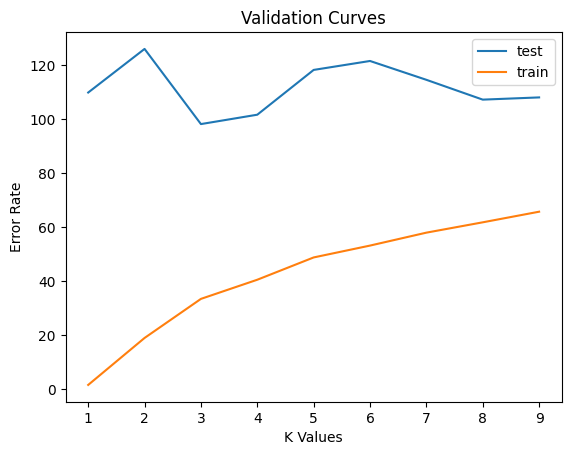

In [32]:
params = [1,2,3,4,5,6,7,8,9]
train_errors = []
test_errors = []
train, test = create_train_test(folds, 0)
test_labels = [row[8] for row in test]
train_labels = [row[8] for row in train]

for i in range(len(params)):
    # call KNN
    train_pred = knn(train, train, params[i])
    test_pred =knn(train, test, params[i])
    # evaluate
    train_mse = mse(train_labels, train_pred)
    test_mse = mse(test_labels, test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

plot_val_curves(params, test_errors, train_errors)

### Problem 3 Discussion
- Tuning was done by creating a validation curve. 
- The curve plotted the error rate of the training and the testing data sets separately
- The Value of K with the lowest error for the test set was 3.
- When the value of k was 1 for the training set, the error rate was zero, as expected. This is because it is predicting off of the actual value. The K=1 for the training set is not really a neighbor
- The test error rate is significantly higher than the training error rate. Adding more data could help improve this model


## Problem 4: Generalization Error

Analyze and discuss the generalization error of your model with the value of k from Problem 3.

In [33]:
errors = []
for i in range(10):
    train, test = create_train_test(folds, i)
    test_labels = [row[8] for row in test]

    knn_preds = knn(train, test, 3) # using the optimal param from prev problem
    error_rate = mse(test_labels, knn_preds)
    errors.append(error_rate)
print_errors(errors, "3 Nearest Neighbors")

Error Rate for model 3 Nearest Neighbors
Fold 1 error rate: 98.0986
Fold 2 error rate: 76.3839
Fold 3 error rate: 59.7684
Fold 4 error rate: 49.9689
Fold 5 error rate: 76.0549
Fold 6 error rate: 79.9068
Fold 7 error rate: 71.5664
Fold 8 error rate: 79.7444
Fold 9 error rate: 65.082
Fold 10 error rate: 83.5817
Mean= 74.01559999999999


### Problem 4 Discussion
- The generalization error gives us insight on how well our model can make predictions with unknown data
- The error rate collected is only based on making predictions of the test set
- Compared the 9NN and the Null mode, the 3NN performed much better. 3NN had the lowest error rate

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

In [34]:
# Z Score Normalization
errors = []
for i in range(10):
    train, test = create_train_test(folds, i)
    test_new = z_score(train, test)
    train_new =  z_score(train, train)
    test_labels = [row[8] for row in test]

    knn_preds = knn(train_new, test_new, 3) # using the optimal param from prev problem
    error_rate = mse(test_labels, knn_preds)
    errors.append(error_rate)
print_errors(errors, "3 Nearest Neighbors")

Error Rate for model 3 Nearest Neighbors
Fold 1 error rate: 104.8352
Fold 2 error rate: 63.8911
Fold 3 error rate: 59.804
Fold 4 error rate: 55.7595
Fold 5 error rate: 65.5548
Fold 6 error rate: 76.7593
Fold 7 error rate: 61.9933
Fold 8 error rate: 75.4078
Fold 9 error rate: 72.4915
Fold 10 error rate: 89.8082
Mean= 72.63046999999999


### Problem 5 Discussion
- Normalizing the data did improve my model a little bit. 
- The previous 3NN without normalization had an average error of 74.0 and my 3NN normalized had an error rate of 72.6
- My understanding of normalizing the data is that you use the training datas mean and standard deviation in the z score formula when transforming both the test and training set, but maybe that is not correct. 

### Comments
- I didn't have difficulties implementing any of the logic for KNN or the metrics
- But I wasn't 100% sure about the formatting of the output. I tried following the course notes provided, but it still wasn't clear to me the format for some of the problems like problem 1 and 2. 

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.